# Design Pattern 11 - Useful Overfitting (Chapter 4)

## Introduction to Overfitting

Generally when we first learn machine learning, overfitting to the training data is undesirable. We aim for a generalisable model suitable for a range of unseen data e.g. a future prediction in time (see Design Pattern 7: Ensembles).

![overfitting](Images/overfitting.jpeg)

![overfit_underfit](Images/overfitting-vs-underfitting.png)

## When overfitting becomes useful (weather/ climate example)

Unlike most machine learning models, forecasting physical/ dynamical systems using machine learning is different and our approach to overfitting changes.

Traditionally the behaviour of these dynamical systems (climate, biology, weather, etc.) are simulated using numerical equations, specifically the Navier-Stokes partial differential equations (a variation of the Euler equations taking into account viscosity). 

![navier-stokes](Images/navier_stokes.jpg)

As we know in weather/ climate, determining solutions for ordinary differential equations (ODEs) often uses numerical methods such as finite difference e.g. Runge-Kutta methods. However the spatial box size must be small enough to capture the smallest feature size of the solution (CFL-criterion) so when moving to higher resolution, the spatial and temporal grid must be scaled accordingly at a much greater computational cost. 

We can use deep learning approaches (neural networks) to approximate the precise solution of these different equations as a much faster rate e.g. https://arxiv.org/abs/2212.12794 and https://arxiv.org/abs/1808.04930 . 

When building a ML model to simulate a dynamical system, overfitting doesn’t exist! We actually want the model to ‘overfit’ to the training data to get the closest possible solution as the ‘true’ model. If the loss reaches zero, the model has found the solution of the PDE. 
Overfitting is useful when two conditions are met:
    
1. There’s no noise so the labels for each input are accurate
2. You start with the complete dataset so overfitting becomes interpolating the dataset i.e. there’s no unseen data.

Note you have to take care with inferences made on rounded-off values of the inputs (the rounding is determined by the resolution of the input data).
However these conditions result in a narrow use case. 



## A compromise

When at least one of these conditions is relaxed, overfitting can still become useful. Examples are described below:

### Interpolation

1. When you create a finite number of observations the model is trying to predict e.g. defining the minimum, maximum and the increment of the variable.  If the system is not chaotic, the machine learning model can then interpolate the unseen values by their distance from the training examples. 

2. When it’s unfeasible or not physically possible to use all possible inputs, you could take a Monte Carlo approach of sampling the input space to create a set of inputs. The machine learning model is again interpolating between known answers, is deterministic and the known answers don’t contain noise.  Note the model complexity is limited in this case.

### Data-driven discretizations of PDEs

3. As mentioned above, as well as using a piecewise polynomial interpolation via standard finite-difference methods to approximate a PDE solution, neural networks can be used which vastly outperform the numerical simulation for the absolute error, at a much lower compute cost. Techniques such as the ‘Deep Galerkin’ method then use deep learning to provide a mesh-free approximation of the PDE solution. Solving the PDE this way is similar to the chained optimization problem of Design Pattern 8: Cascade.  The ‘Deep Galerkin’ method is a deep learning algorithm used to approximate the solution of PDEs, based on the ‘Galerkin’ method in mathematics: https://arxiv.org/abs/2201.12995.

### Knowledge transfer 

4. Overfitting is useful when transferring knowledge from a large ML model into a smaller one. A smaller model can be trained on data generated by the larger model; where the smaller model solves a simpler problem by learning the soft output of the large model, instead of the actual labels on the real data, and therefore overfitting can be used.

### Sanity check on small batch of data

5. Overfitting on a small batch of data is a good sanity check for the model architecture (e.g. choice of learning rate, weight initializations etc.) and for the data pipeline. A complex enough model should overfit on a small batch of data. If your deep neural network doesn’t overfit on your training data, the training set needs increasing. When it does overfit, you can apply regularization to improve the validation accuracy, reducing the training accuracy. 




## Overfitting on a batch python implementation

Setting up environment:

conda env create --file requirement_tensorflow.yml

conda activate data-science-cop-tf

In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow import feature_column as fc
from tensorflow.keras import layers, models, Model
%matplotlib inline

2023-01-13 10:18:51.918812: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
df = pd.read_csv("/project/informatics_lab/data_science_cop/design_patterns_samples/baby_weight_data/babyweight_train.csv")


In [22]:
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,mother_race
0,7.749249,False,12,Single(1),40,1.0
1,7.561856,True,12,Single(1),40,2.0
2,7.187070,False,12,Single(1),34,3.0
3,6.375769,True,12,Single(1),36,2.0
4,7.936641,False,12,Single(1),35,NaN


Set up model features

In [23]:
# prepare inputs
df.is_male = df.is_male.astype(str)

df.mother_race.fillna(0, inplace = True)
df.mother_race = df.mother_race.astype(str)

FEATURES = ['is_male', 'mother_age', 'plurality', 'gestation_weeks', 'mother_race']
LABEL = ['weight_pounds']

N_TRAIN = int(df.shape[0] * 0.80)

X_train = df[FEATURES][:N_TRAIN]
X_valid = df[FEATURES][N_TRAIN:]


y_train = df[LABEL][:N_TRAIN]
y_valid = df[LABEL][N_TRAIN:]

Create data input pipeline

In [24]:
# train/validation dataset
trainds = tf.data.Dataset.from_tensor_slices((X_train.to_dict('list'), y_train.values))
evalds = tf.data.Dataset.from_tensor_slices((X_valid.to_dict('list'), y_valid.values))

# Examine the datasets.
for dict_slice in trainds.take(1):
        print("{}\n".format(dict_slice))

({'is_male': <tf.Tensor: shape=(), dtype=string, numpy=b'False'>, 'mother_age': <tf.Tensor: shape=(), dtype=int32, numpy=12>, 'plurality': <tf.Tensor: shape=(), dtype=string, numpy=b'Single(1)'>, 'gestation_weeks': <tf.Tensor: shape=(), dtype=int32, numpy=40>, 'mother_race': <tf.Tensor: shape=(), dtype=string, numpy=b'1.0'>}, <tf.Tensor: shape=(1,), dtype=float64, numpy=array([7.74924851])>)



Set up feature columns

In [25]:
# create feature columns to handle categorical variables
numeric_columns = [fc.numeric_column("mother_age"),
                  fc.numeric_column("gestation_weeks")]

CATEGORIES = {
    'plurality': list(df.plurality.unique()),
    'is_male' : list(df.is_male.unique()),
    'mother_race': list(df.mother_race.unique())
}

categorical_columns = []
for feature, vocab in CATEGORIES.items():
    cat_col = fc.categorical_column_with_vocabulary_list(
        key=feature, vocabulary_list=vocab, dtype=tf.string)
    categorical_columns.append(fc.indicator_column(cat_col))

Build a simple neural network

In [26]:
# create Inputs for model
inputs = {colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype="float32")
    for colname in ["mother_age", "gestation_weeks"]}
inputs.update({colname: tf.keras.layers.Input(
    name=colname, shape=(), dtype=tf.string)
    for colname in ["plurality", "is_male", "mother_race"]})

# build DenseFeatures for the model
dnn_inputs = layers.DenseFeatures(categorical_columns+numeric_columns)(inputs)

# create hidden layers
h1 = layers.Dense(20, activation="relu")(dnn_inputs)
h2 = layers.Dense(10, activation="relu")(h1)

# create model
output = layers.Dense(1, activation="relu")(h2)
model = tf.keras.models.Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse'])   

We can inspect our train data pipeline by pulling a singe batch of 5 examples.

In [27]:
for feature_batch, label_batch in trainds.batch(5).take(1):
    print("'babyweight': {}".format(label_batch))
    print("features:")
    for key, value in feature_batch.items():
      print("  {!r:20s}: {}".format(key, value))

'babyweight': [[7.74924851]
 [7.56185559]
 [7.18706974]
 [6.37576862]
 [7.93664143]]
features:
  'is_male'           : [b'False' b'True' b'False' b'True' b'False']
  'mother_age'        : [12 12 12 12 12]
  'plurality'         : [b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)' b'Single(1)']
  'gestation_weeks'   : [40 40 34 36 35]
  'mother_race'       : [b'1.0' b'2.0' b'3.0' b'2.0' b'0.0']


For training, we'll take a larger batch and call it single_batch.

Then we train the model on the single batch. Note we must use .repeat() since we'll quickly run out of data training on just a single batch. Also, we've set the number of training examples to BATCH_SIZE.

In [28]:
BATCH_SIZE = 256

single_batch = trainds.batch(BATCH_SIZE).take(1)

# train the classifcation model
tf.random.set_seed(33)

NUM_TRAINING_EXAMPLES = BATCH_SIZE  # total number of training examples
NUM_VALID_EXAMPLES = X_valid.shape[0]
NUM_EPOCHS = 100
TOTAL_TRAINING_EXAMPLES = int(NUM_EPOCHS * NUM_TRAINING_EXAMPLES)

steps_per_epoch = (TOTAL_TRAINING_EXAMPLES // (BATCH_SIZE * NUM_EPOCHS))

evalds = evalds.batch(X_valid.shape[0]).take(int(NUM_VALID_EXAMPLES//BATCH_SIZE))

# train the model
history = model.fit(single_batch.repeat(),
                    validation_data=evalds, 
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=steps_per_epoch,
                    verbose=0
                   )

Plot the validation and training loss curves

In [29]:
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');

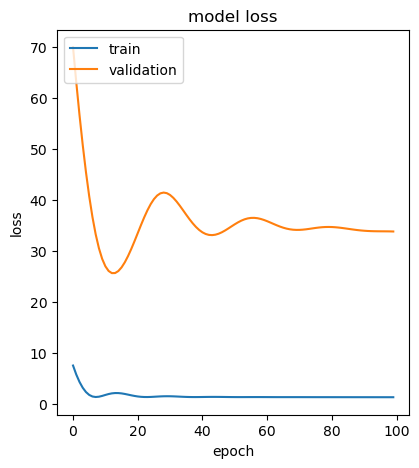

In [30]:
plot_curves(history, ['loss'])

Source code: https://github.com/GoogleCloudPlatform/ml-design-patterns/blob/master/04_hacking_training_loop/overfitting.ipynb